In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from rgf.sklearn import RGFClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [2]:
# Loading the train dataset
path="../Data/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [3]:
train.nunique()

ID                             68654
customer_id                     6540
country_id                         1
tbl_loan_id                    66520
lender_id                          4
loan_type                         22
Total_Amount                   19076
Total_Amount_to_Repay          21920
disbursement_date                768
due_date                         893
duration                          64
New_versus_Repeat                  2
Amount_Funded_By_Lender        23391
Lender_portion_Funded          12844
Lender_portion_to_be_repaid     9791
target                             2
dtype: int64

In [4]:
test.nunique()

ID                             18594
customer_id                     4962
country_id                         2
tbl_loan_id                    17067
lender_id                          8
loan_type                         22
Total_Amount                    9372
Total_Amount_to_Repay          10963
disbursement_date                656
due_date                         728
duration                          50
New_versus_Repeat                  2
Amount_Funded_By_Lender         9704
Lender_portion_Funded           3880
Lender_portion_to_be_repaid     6782
dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [6]:
[x for x in train.columns if "_id" in x.lower() or x.lower()=="id"]

['ID', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id']

In [ ]:
train["New_versus_Repeat"].value_counts()

New_versus_Repeat
Repeat Loan    68087
New Loan         567
Name: count, dtype: int64

In [8]:
class Preprocessing :
    def __init__(self, train, test) :
        self.train = train 
        self.test = test
        self.train_shape = train.shape
        self.test_shape = test.shape
        self.train_columns = train.columns
        self.test_columns = test.columns
        self.id_cols = [x for x in train.columns if "_id" in x.lower() or x.lower()=="id"]
        self.target_col = self.train.columns.difference(self.test.columns)
        self.date_cols = [x for x in train.columns if "date" in x.lower()]
        self.cat_cols = [x for x in train.columns if train[x].dtype=="O" and x not in self.id_cols and x not in self.date_cols]
        self.num_cols = [x for x in train.columns if x not in self.cat_cols and x not in self.id_cols and x not in self.target_col and x not in self.date_cols]
        self.test_ids = self.test[self.id_cols]
        
    
    def all_data(self) :
        return pd.concat([self.train, self.test], axis=0)   
    
    def drop_id_cols(self) :
        self.train.drop(columns=self.id_cols, inplace=True)
        self.test.drop(columns=self.id_cols, inplace=True)
        return self.train, self.test
    
    def standardize(self) :
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        self.train[self.num_cols] = scaler.fit_transform(self.train[self.num_cols])
        self.test[self.num_cols] = scaler.transform(self.test[self.num_cols])
        return self.train, self.test
    
    def frequency_encoding_cat_cols(self) :
        for col in self.cat_cols :
            encoding = self.all_data()[col].value_counts()
            self.train[col] = self.train[col].map(encoding)
            self.test[col] = self.test[col].map(encoding)
        return self.train, self.test
    
    def fillna(self) :
        self.train.fillna(0, inplace=True)
        self.test.fillna(0, inplace=True)
        return self.train, self.test
    
    def feature_engineering_num_cols(self) :
        for col in self.num_cols :
            self.train[col+"_squared"] = self.train[col]**2
            self.train[col+"_cubed"] = self.train[col]**3
            self.train[col+"_sqrt"] = np.sqrt(self.train[col])
            self.train[col+"_log"] = np.log(self.train[col]+1)
            
            self.test[col+"_squared"] = self.test[col]**2
            self.test[col+"_cubed"] = self.test[col]**3
            self.test[col+"_sqrt"] = np.sqrt(self.test[col])
            self.test[col+"_log"] = np.log(self.test[col]+1)
        return self.train, self.test
    
    def feature_engineering_date_cols(self) :
        for col in self.date_cols :
            self.train[col+"_year"] = pd.to_datetime(self.train[col]).dt.year
            self.train[col+"_month"] = pd.to_datetime(self.train[col]).dt.month
            self.train[col+"_day"] = pd.to_datetime(self.train[col]).dt.day
            self.train[col+"_dayofweek"] = pd.to_datetime(self.train[col]).dt.dayofweek
            self.train[col+"_weekofyear"] = pd.to_datetime(self.train[col]).dt.isocalendar().week
            
            self.test[col+"_year"] = pd.to_datetime(self.test[col]).dt.year
            self.test[col+"_month"] = pd.to_datetime(self.test[col]).dt.month
            self.test[col+"_day"] = pd.to_datetime(self.test[col]).dt.day
            self.test[col+"_dayofweek"] = pd.to_datetime(self.test[col]).dt.dayofweek
            self.test[col+"_weekofyear"] = pd.to_datetime(self.test[col]).dt.isocalendar().week
            
        self.train.drop(columns=self.date_cols, inplace=True)
        self.test.drop(columns=self.date_cols, inplace=True)
        
        # ir mean by lender_id
        self.train["ir_mean_by_disbursement_date_year"] = self.train.groupby("disbursement_date_year")["interest_rate"].transform("mean")
        self.test["ir_mean_by_disbursement_date_year"] = self.test.groupby("disbursement_date_year")["interest_rate"].transform("mean")
        
        # ir variance by lender_id
        self.train["ir_variance_by_disbursement_date_year"] = self.train.groupby("disbursement_date_year")["interest_rate"].transform("var")
        self.test["ir_variance_by_disbursement_date_year"] = self.test.groupby("disbursement_date_year")["interest_rate"].transform("var")
        
        # ir skewness by lender_id
        self.train["ir_skewness_by_disbursement_date_year"] = self.train.groupby("disbursement_date_year")["interest_rate"].transform("skew")
        self.test["ir_skewness_by_disbursement_date_year"] = self.test.groupby("disbursement_date_year")["interest_rate"].transform("skew")
        
        # ir kurtosis by lender_id
        self.train["ir_kurtosis_by_disbursement_date_year"] = self.train.groupby("disbursement_date_year")["interest_rate"].apply(pd.Series.kurt)
        self.test["ir_kurtosis_by_disbursement_date_year"] = self.test.groupby("disbursement_date_year")["interest_rate"].apply(pd.Series.kurt)
        
        return self.train, self.test
    
    def credit_scoring_feature_engineering(self) :
        # convert dates
        for col in self.date_cols :
            self.train[col] = pd.to_datetime(self.train[col])
            self.test[col] = pd.to_datetime(self.test[col])
        # loan amount ratio
        self.train["loan_to_income"] = self.train["Total_Amount"]/self.train["Total_Amount_to_Repay"]
        self.test["loan_to_income"] = self.test["Total_Amount"]/self.test["Total_Amount_to_Repay"]
        # repayment duration in days
        self.train["repayment_duration"] = (self.train["due_date"] - self.train["disbursement_date"]).dt.days
        self.test["repayment_duration"] = (self.test["due_date"] - self.test["disbursement_date"]).dt.days
        # lender funded ratio
        self.train["lender_funded_ratio"] = self.train["Amount_Funded_By_Lender"]/self.train["Total_Amount"]
        self.test["lender_funded_ratio"] = self.test["Amount_Funded_By_Lender"]/self.test["Total_Amount"]
        
        # loan to duration ratio
        self.train["loan_to_duration_ratio"] = self.train["Total_Amount"]/self.train["repayment_duration"]
        self.test["loan_to_duration_ratio"] = self.test["Total_Amount"]/self.test["repayment_duration"]
        # lender portion ratio
        self.train["lender_portion_ratio"] = self.train["Lender_portion_Funded"]/self.train["Total_Amount"]
        self.test["lender_portion_ratio"] = self.test["Lender_portion_Funded"]/self.test["Total_Amount"]
        # lender repayment ratio
        self.train["lender_repayment_ratio"] = self.train["Lender_portion_to_be_repaid"]/self.train["Total_Amount_to_Repay"]
        self.test["lender_repayment_ratio"] = self.test["Lender_portion_to_be_repaid"]/self.test["Total_Amount_to_Repay"]
        # customer loan count 
        self.train["customer_loan_count"] = self.train.groupby("customer_id")["tbl_loan_id"].transform("count")
        self.test["customer_loan_count"] = self.test.groupby("customer_id")["tbl_loan_id"].transform("count")
        # average loan amount per customer
        self.train["average_loan_amount_per_customer"] = self.train.groupby("customer_id")["Total_Amount"].transform("mean")
        self.test["average_loan_amount_per_customer"] = self.test.groupby("customer_id")["Total_Amount"].transform("mean")
        
        # interest rate
        self.train["interest_rate"] = (self.train['Total_Amount_to_Repay'] - self.train['Total_Amount']) / self.train['Total_Amount']
        self.test["interest_rate"] = (self.test['Total_Amount_to_Repay'] - self.test['Total_Amount']) / self.test['Total_Amount']
        
        # ir mean by lender_id
        self.train["ir_mean_by_lender_id"] = self.train.groupby("lender_id")["interest_rate"].transform("mean")
        self.test["ir_mean_by_lender_id"] = self.test.groupby("lender_id")["interest_rate"].transform("mean")
        
        # ir variance by lender_id
        self.train["ir_variance_by_lender_id"] = self.train.groupby("lender_id")["interest_rate"].transform("var")
        self.test["ir_variance_by_lender_id"] = self.test.groupby("lender_id")["interest_rate"].transform("var")
        
        # ir skewness by lender_id
        self.train["ir_skewness_by_lender_id"] = self.train.groupby("lender_id")["interest_rate"].transform("skew")
        self.test["ir_skewness_by_lender_id"] = self.test.groupby("lender_id")["interest_rate"].transform("skew")
        
        # ir kurtosis by lender_id
        self.train["ir_kurtosis_by_lender_id"] = self.train.groupby("lender_id")["interest_rate"].apply(pd.Series.kurt)
        self.test["ir_kurtosis_by_lender_id"] = self.test.groupby("lender_id")["interest_rate"].apply(pd.Series.kurt)
        
        return self.train, self.test
    
    def feature_engineering(self) :
        # self.feature_engineering_num_cols()
        self.credit_scoring_feature_engineering()
        self.feature_engineering_date_cols()
        return self.train, self.test
    
    def replace_inf(self) :
        self.train.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.test.replace([np.inf, -np.inf], np.nan, inplace=True)
        return self.train, self.test
    
    def preprocess(self) :
        self.feature_engineering()
        self.drop_id_cols()
        self.standardize()
        self.frequency_encoding_cat_cols()
        self.replace_inf()
        self.fillna()
        return self.train, self.test
    
preprocessor = Preprocessing(train, test)
train, test = preprocessor.preprocess()
    

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   loan_type                              68654 non-null  int64  
 1   Total_Amount                           68654 non-null  float64
 2   Total_Amount_to_Repay                  68654 non-null  float64
 3   duration                               68654 non-null  float64
 4   New_versus_Repeat                      68654 non-null  int64  
 5   Amount_Funded_By_Lender                68654 non-null  float64
 6   Lender_portion_Funded                  68654 non-null  float64
 7   Lender_portion_to_be_repaid            68654 non-null  float64
 8   target                                 68654 non-null  int64  
 9   loan_to_income                         68654 non-null  float64
 10  repayment_duration                     68654 non-null  int64  
 11  le

In [10]:
train["due_date_year"].value_counts()

due_date_year
2022    64235
2024     3102
2023     1284
2021       27
2025        6
Name: count, dtype: int64

In [11]:
train["disbursement_date_year"].value_counts()

disbursement_date_year
2022    64405
2024     2970
2023     1240
2021       39
Name: count, dtype: int64

In [12]:
test["disbursement_date_year"].value_counts()

disbursement_date_year
2022    17249
2023      688
2024      629
2021       28
Name: count, dtype: int64

In [13]:
train.target.value_counts()

target
0    67396
1     1258
Name: count, dtype: int64

In [ ]:


# Create edge index (for simplicity, using a fully connected graph)
num_nodes = train.shape[0]
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()

# Create node features
x = torch.tensor(train.drop(columns="target").values, dtype=torch.float)
y = torch.tensor(train["target"].values, dtype=torch.long)

# Create data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 2)  # Assuming binary classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Evaluate the model
model.eval()
_, pred = model(data).max(dim=1)
f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='weighted')
print('F1 Score: {:.4f}'.format(f1))

In [65]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=98)
models = {
    "LogisticRegression" : LogisticRegression(max_iter=1000000),
    "RandomForest" : RandomForestClassifier(),
    "SVC" : SVC(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "LGBM" : LGBMClassifier(),
    "XGB" : XGBClassifier(),
    "CatBoost" : CatBoostClassifier(),
    "RGF" : RGFClassifier(),
    "GradientBoosting" : GradientBoostingClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "ExtraTrees" : ExtraTreesClassifier(),
    "Bagging" : BaggingClassifier(),
    "Voting" : VotingClassifier(estimators=[("lgbm", LGBMClassifier()), ("xgb", XGBClassifier()), ("cat", CatBoostClassifier()),
                                             ("rgf", RGFClassifier()), ("rf", RandomForestClassifier())]),
    "Stacking" : StackingClassifier(estimators=[("lgbm", LGBMClassifier()), ("xgb", XGBClassifier()), ("cat", CatBoostClassifier()),
                                             ("rgf", RGFClassifier()), ("rf", RandomForestClassifier())])
}

In [67]:
class ModelBenchmarching:
    def __init__(self, models, cv, train, test):
        self.models = models
        self.cv = cv
        self.results = {}
        self.train = train
        self.X = self.train.drop(columns="target")
        self.y = self.train.target
        self.X_test = test[self.X.columns]
        self.skf = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=98)
        
    def fit(self):
        for name, model in self.models.items():
            accuracy = []
            f1 = []
            precision = []
            recall = []
            roc = []
            for train_idx, test_idx in self.skf.split(self.X, self.y):
                X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
                y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy.append(accuracy_score(y_test, y_pred))
                f1.append(f1_score(y_test, y_pred))
                precision.append(precision_score(y_test, y_pred))
                recall.append(recall_score(y_test, y_pred))
                roc.append(roc_auc_score(y_test, y_pred))
            self.results[name] = {
                "accuracy" : np.mean(accuracy),
                "f1" : np.mean(f1),
                "precision" : np.mean(precision),
                "recall" : np.mean(recall),
                "roc" : np.mean(roc)
            }
        return self.results
    
    def plot_results(self):
        results = pd.DataFrame(self.results)
        results.plot(kind="bar", figsize=(15, 6))
        plt.xticks(rotation=0)
        plt.show()
        
    def predict(self):
        for name, model in self.models.items():
            model.fit(self.X, self.y)
            self.X_test["target"] = model.predict(self.X_test)
            self.X_test["ID"] = preprocessor.test_ids["ID"]
            self.X_test[["ID", "target"]].to_csv(f"{name}.csv", index=False)
            self.X_test.drop(columns=["ID", "target"], inplace=True)
    
    def ensembling_top_5_f1(self):
        models = list(self.results.keys())
        models = sorted(models, key=lambda x: self.results[x]["f1"], reverse=True)[:5]
        for name in models:
            model = self.models[name]
            model.fit(self.X, self.y)
            self.X_test["target"] = model.predict(self.X_test)
            self.X_test["ID"] = preprocessor.test_ids["ID"]
            self.X_test[["ID", "target"]].to_csv(f"../Submissions/{name}.csv", index=False)
            self.X_test.drop(columns=["ID", "target"], inplace=True)
    
    def cross_val_predict_top_3_f1(self):
        models = list(self.results.keys())
        models = sorted(models, key=lambda x: self.results[x]["f1"], reverse=True)[:3]
        for name in models:
            model = self.models[name]
            y_preds = np.zeros(self.X_test.shape[0])
            for train_idx, test_idx in self.skf.split(self.X, self.y):
                X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
                y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
                model.fit(X_train, y_train)
                y_preds += model.predict(self.X_test)
            self.X_test["target"] = y_preds/self.cv
            self.X_test["ID"] = preprocessor.test_ids["ID"]
            self.X_test[["ID", "target"]].to_csv(f"../Submissions/crossval_{name}.csv", index=False)
            self.X_test.drop(columns=["ID", "target"], inplace=True)
        
    def average_top_5_f1(self):
        models = list(self.results.keys())
        models = sorted(models, key=lambda x: self.results[x]["f1"], reverse=True)[:5]
        averages = np.zeros(self.X_test.shape[0])
        for name in models:
            model = self.models[name]
            model.fit(self.X, self.y)
            averages += model.predict(self.X_test)
        self.X_test["target"] = averages/5
        self.X_test["ID"] = preprocessor.test_ids["ID"]
        self.X_test[["ID", "target"]].to_csv("../Submissions/average_top_5_f1.csv", index=False)
        self.X_test.drop(columns=["ID", "target"], inplace=True)
            
    
model_benchmarching = ModelBenchmarching(models, 5, train, test)
        
        

In [68]:
model_benchmarching.fit()

c:\Users\origin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\origin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[LightGBM] [Info] Number of positive: 1007, number of negative: 53916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3494
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018335 -> initscore=-3.980452
[LightGBM] [Info] Start training from score -3.980452
[LightGBM] [Info] Number of positive: 1006, number of negative: 53917
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3493
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 33
[LightGBM] [Info] [b

c:\Users\origin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\origin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\origin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\origin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users

[LightGBM] [Info] Number of positive: 1007, number of negative: 53916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3494
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018335 -> initscore=-3.980452
[LightGBM] [Info] Start training from score -3.980452
Learning rate set to 0.056991
0:	learn: 0.5254990	total: 30.3ms	remaining: 30.3s
1:	learn: 0.4119798	total: 48.8ms	remaining: 24.4s
2:	learn: 0.3285966	total: 76.2ms	remaining: 25.3s
3:	learn: 0.2469245	total: 102ms	remaining: 25.4s
4:	learn: 0.2035310	total: 128ms	remaining: 25.5s
5:	learn: 0.1648629	total: 153ms	remaining: 25.4s
6:	learn: 0.1325080	total: 178ms	remaining: 25.2s
7:	learn: 0.1032374	total: 209ms	remaining: 25.9s
8:	learn: 

{'LogisticRegression': {'accuracy': 0.9816762332196782,
  'f1': 0.16111958630428122,
  'precision': 0.5532916545884837,
  'recall': 0.09772655410105609,
  'roc': 0.5479507486488359},
 'RandomForest': {'accuracy': 0.996227454975459,
  'f1': 0.8926242977923096,
  'precision': 0.9334913251892216,
  'recall': 0.8553215708594195,
  'roc': 0.927089531937906},
 'SVC': {'accuracy': 0.9817781922903942,
  'f1': 0.026430018277338586,
  'precision': 0.65,
  'recall': 0.013514197179535826,
  'roc': 0.5066829096602032},
 'KNeighbors': {'accuracy': 0.9815742762706785,
  'f1': 0.20666422041215377,
  'precision': 0.4888401342361607,
  'recall': 0.13115158413963196,
  'roc': 0.5642997539289383},
 'DecisionTree': {'accuracy': 0.995149595577028,
  'f1': 0.8684603601163433,
  'precision': 0.8651314123198608,
  'recall': 0.8720230190349711,
  'roc': 0.9347354664233045},
 'LGBM': {'accuracy': 0.9959798379677185,
  'f1': 0.8872309912390464,
  'precision': 0.9126768740496072,
  'recall': 0.8632580787959274,
  

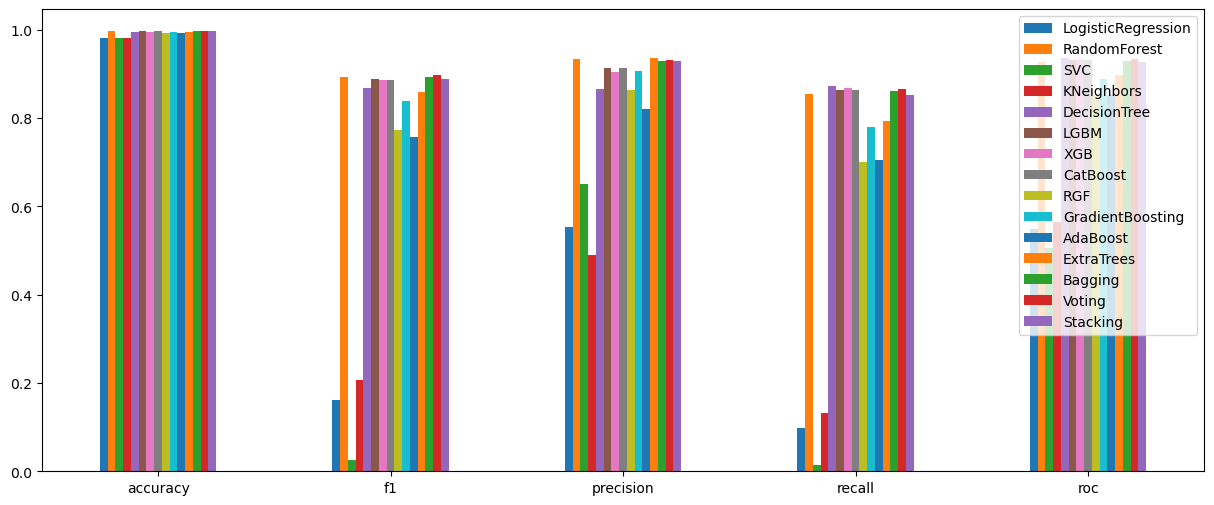

In [69]:
model_benchmarching.plot_results()

In [76]:
model_benchmarching.cross_val_predict_top_3_f1()

[LightGBM] [Info] Number of positive: 1007, number of negative: 53916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8736
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018335 -> initscore=-3.980452
[LightGBM] [Info] Start training from score -3.980452
[LightGBM] [Info] Number of positive: 1006, number of negative: 53917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8731
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018317 -> initscore=-3.981464
[LightGBM] [Info] Start training from score -3.981464
[LightGBM] [In

In [16]:
model_benchmarching.average_top_5_f1()

Learning rate set to 0.062689
0:	learn: 0.4816766	total: 23.2ms	remaining: 23.2s
1:	learn: 0.3795851	total: 46.3ms	remaining: 23.1s
2:	learn: 0.2810576	total: 63.4ms	remaining: 21.1s
3:	learn: 0.2030641	total: 81.3ms	remaining: 20.2s
4:	learn: 0.1519495	total: 99.6ms	remaining: 19.8s
5:	learn: 0.1138970	total: 118ms	remaining: 19.5s
6:	learn: 0.0880194	total: 138ms	remaining: 19.6s
7:	learn: 0.0707859	total: 160ms	remaining: 19.8s
8:	learn: 0.0579787	total: 178ms	remaining: 19.6s
9:	learn: 0.0488617	total: 197ms	remaining: 19.5s
10:	learn: 0.0427116	total: 216ms	remaining: 19.4s
11:	learn: 0.0383567	total: 237ms	remaining: 19.5s
12:	learn: 0.0351152	total: 257ms	remaining: 19.5s
13:	learn: 0.0322762	total: 277ms	remaining: 19.5s
14:	learn: 0.0304869	total: 297ms	remaining: 19.5s
15:	learn: 0.0287713	total: 321ms	remaining: 19.7s
16:	learn: 0.0272813	total: 340ms	remaining: 19.6s
17:	learn: 0.0253679	total: 359ms	remaining: 19.6s
18:	learn: 0.0243217	total: 379ms	remaining: 19.6s
19:	le

In [46]:
pd.DataFrame(model_benchmarching.results)

,LogisticRegression,RandomForest,SVC,KNeighbors,DecisionTree,LGBM,XGB,CatBoost,RGF,GradientBoosting,AdaBoost,ExtraTrees,Bagging,Voting,Stacking
accuracy,0.981793,0.996431,0.981778,0.981574,0.995135,0.995980,0.995849,0.996082,0.992455,0.994567,0.991741,0.995849,0.996140,0.996373,0.996417
f1,0.071341,0.899304,0.026430,0.206664,0.868237,0.887061,0.884052,0.889951,0.772683,0.840594,0.757516,0.879893,0.890860,0.897750,0.898787
precision,0.573600,0.931135,0.650000,0.488840,0.863261,0.914070,0.905984,0.916610,0.862548,0.908850,0.819298,0.936353,0.923973,0.928781,0.931944
recall,0.038165,0.869633,0.013514,0.131152,0.873604,0.861677,0.863283,0.864858,0.700323,0.782220,0.705088,0.829896,0.860083,0.868829,0.868039
roc,0.518786,0.934215,0.506683,0.564300,0.935504,0.930082,0.930803,0.931695,0.849115,0.890376,0.851090,0.914421,0.929381,0.933792,0.933426


In [70]:
pd.DataFrame(model_benchmarching.results)

,LogisticRegression,RandomForest,SVC,KNeighbors,DecisionTree,LGBM,XGB,CatBoost,RGF,GradientBoosting,AdaBoost,ExtraTrees,Bagging,Voting,Stacking
accuracy,0.981676,0.996227,0.981778,0.981574,0.995150,0.995980,0.995863,0.995965,0.992455,0.994494,0.991741,0.995222,0.996227,0.996373,0.996096
f1,0.161120,0.892624,0.026430,0.206664,0.868460,0.887231,0.884931,0.886765,0.772683,0.838296,0.757516,0.858835,0.893215,0.897487,0.889019
precision,0.553292,0.933491,0.650000,0.488840,0.865131,0.912677,0.903628,0.912493,0.862548,0.906561,0.819298,0.935525,0.928270,0.931054,0.928586
recall,0.097727,0.855322,0.013514,0.131152,0.872023,0.863258,0.867245,0.862464,0.700323,0.779836,0.705088,0.794106,0.860912,0.866433,0.852928
roc,0.547951,0.927090,0.506683,0.564300,0.934735,0.930857,0.932755,0.930461,0.849115,0.889169,0.851090,0.896541,0.929833,0.932615,0.925848


In [71]:
sorted(model_benchmarching.results.items(), key=lambda x: x[1]["f1"], reverse=True)

[('Voting',
  {'accuracy': 0.9963731129124834,
   'f1': 0.8974870819307913,
   'precision': 0.9310539058632508,
   'recall': 0.8664326819705306,
   'roc': 0.9326154133525899}),
 ('Bagging',
  {'accuracy': 0.9962274602797494,
   'f1': 0.8932151483865001,
   'precision': 0.9282695107465104,
   'recall': 0.8609119079238601,
   'roc': 0.9298327722371106}),
 ('RandomForest',
  {'accuracy': 0.996227454975459,
   'f1': 0.8926242977923096,
   'precision': 0.9334913251892216,
   'recall': 0.8553215708594195,
   'roc': 0.927089531937906}),
 ('Stacking',
  {'accuracy': 0.9960963604982489,
   'f1': 0.8890188148831989,
   'precision': 0.9285864141350524,
   'recall': 0.8529279706570543,
   'roc': 0.9258482175983973}),
 ('LGBM',
  {'accuracy': 0.9959798379677185,
   'f1': 0.8872309912390464,
   'precision': 0.9126768740496072,
   'recall': 0.8632580787959274,
   'roc': 0.9308574803643819}),
 ('CatBoost',
  {'accuracy': 0.9959652702644715,
   'f1': 0.88676498553961,
   'precision': 0.9124932352265143

In [72]:
model_benchmarching.ensembling_top_5_f1()

[LightGBM] [Info] Number of positive: 1258, number of negative: 67396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3505
[LightGBM] [Info] Number of data points in the train set: 68654, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018324 -> initscore=-3.981063
[LightGBM] [Info] Start training from score -3.981063
Learning rate set to 0.062689
0:	learn: 0.5206970	total: 46.5ms	remaining: 46.5s
1:	learn: 0.4069988	total: 75.7ms	remaining: 37.8s
2:	learn: 0.2858735	total: 116ms	remaining: 38.6s
3:	learn: 0.2241302	total: 152ms	remaining: 38s
4:	learn: 0.1714612	total: 196ms	remaining: 39s
5:	learn: 0.1352674	total: 242ms	remaining: 40.1s
6:	learn: 0.1029818	total: 283ms	remaining: 40.1s
7:	learn: 0.0808965	total: 324ms	remaining: 40.2s
8:	learn: 0.0649002	total: 365ms	remaining: 40.2s
9:	learn: 0.0549147	total: 41